In [1]:
from datetime import date
import ndjson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

import sys
sys.path.append('../../dutch-chronicles/src/chronicles/')

from entropies.afa import adaptive_filter


## Topical fluctuation using the mean cossim

In [11]:
year_mean_scaled = pd.read_csv('../models/230511_prototypes_day/year_mean_scaled.csv', index_col=0)
year_mean_scaled.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1500,-0.450487,-0.436204,-1.118789,-1.596639,0.160912,-1.060130,-0.381437,1.537432,1.814222,...,1.265216,0.909596,0.629744,0.783440,1.403919,-0.407034,0.989558,0.749352,1.162003,1.722567
1,1501,-0.573618,0.093658,0.536136,0.540725,-1.266153,-2.388546,-2.058296,0.049908,-0.016249,...,1.574999,-0.699661,2.015948,0.681972,0.481077,1.471936,0.002142,-0.393433,0.497257,-0.326851
2,1502,-0.553132,-0.408307,-1.774518,-2.099509,1.224089,-1.752047,2.433999,2.665260,-3.139457,...,-0.788398,-0.371142,-3.698503,-0.037968,-1.556674,0.128143,-0.714775,0.273582,-1.976117,0.788399
3,1503,0.014684,-0.047477,1.991784,-0.597510,1.846066,2.281270,1.442263,2.623932,2.855782,...,1.845165,3.193820,0.746997,0.976570,1.407569,1.692816,2.594493,1.720160,2.226889,1.533249
4,1504,0.235217,-1.296820,0.663842,-0.459664,-0.374312,1.521285,-0.820795,-1.702618,1.119003,...,1.064474,-1.638206,1.407485,-0.547609,-1.872452,-2.760877,-1.029441,-0.773694,0.766962,-1.093739


### Smoothening

Two options:
- Smoothening with a Gaussian kernel
- Smoothening with a linear adaptive filter

### Smoothening with a Gaussian kernel

/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


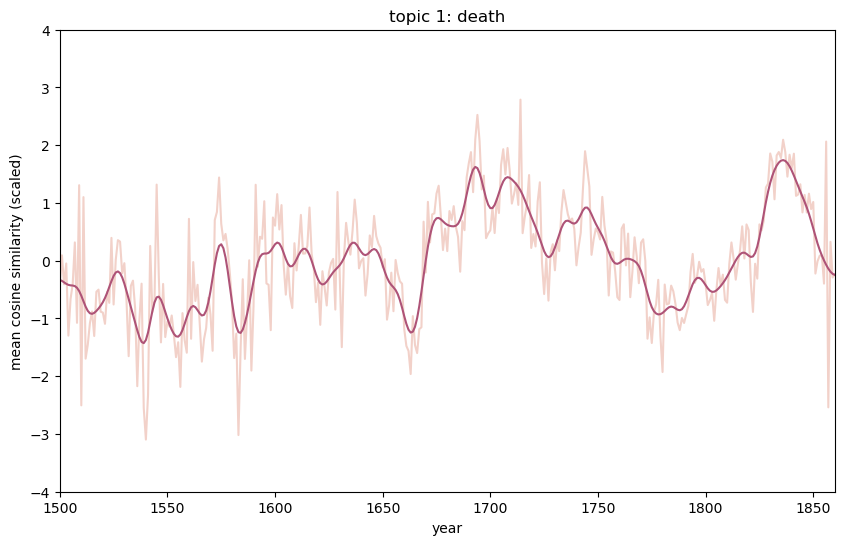

In [17]:
#fig, (axes) = plt.subplots(3, 1, figsize=(4, 12), sharey=False)

topic = [*range(0,100)]
topic = [str(x) for x in topic]

smooth = gaussian_filter1d(year_mean_scaled[topic[1]].to_numpy(), 3)
plt.figure(figsize=(10, 6))
sns.lineplot(year_mean_scaled['year'], year_mean_scaled[topic[1]], color='#F2D1C9')
sns.lineplot(year_mean_scaled['year'], smooth, color='#AE5377')
plt.title('topic 1: death')
plt.xlabel('year')
plt.ylabel('mean cosine similarity (scaled)')
plt.xlim([1500, 1860])
plt.ylim([-4, +4])
plt.show()

#### Smoothening with a linear adaptive filter

In [14]:
weak_smooth = adaptive_filter(year_mean_scaled[topic[0]].to_numpy(), span=51)
#strong_smooth = adaptive_filter(year_mean_scaled[topic[0]].to_numpy(), span=28)

(-3.0, 3.0)

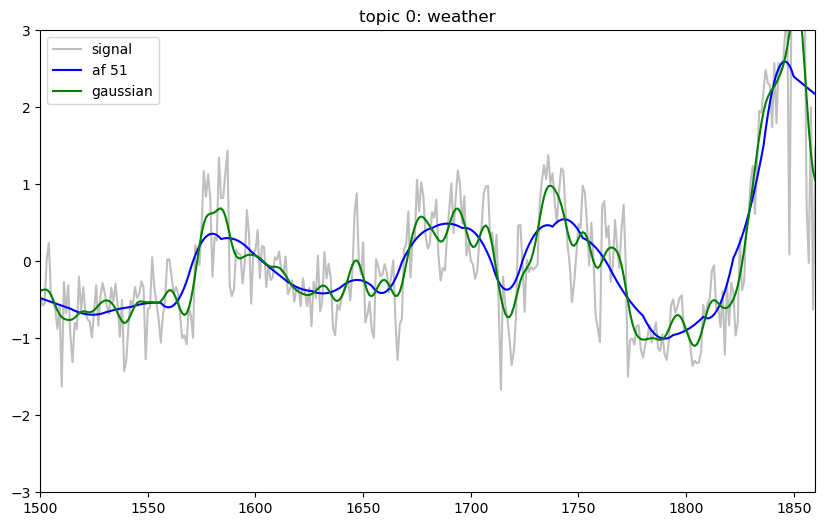

In [16]:
plt.figure(figsize=(10,6))
plt.plot(year_mean_scaled['year'], year_mean_scaled[topic[0]], alpha=0.5, c='grey')
plt.plot(year_mean_scaled['year'], weak_smooth, c='blue')
#plt.plot(year_mean_scaled['year'], strong_smooth, c='green')
plt.plot(year_mean_scaled['year'], smooth, color='green')
#plt.plot(year_mean_scaled['year'], smooth1, c='red')
plt.title('topic 0: weather')
plt.legend(['signal', 'af 51', 'gaussian'])
plt.xlim([1500,1860])
plt.ylim([-3, 3])

## Topical fluctuation using original values in scatter

In [2]:
with open('../models/230511_prototypes_day/cossims_corrected_year_id.ndjson') as f: # of primitives_annotated
    data = ndjson.load(f)

len(data)

76017

In [3]:
data_df = []
for item in data:
    try:
        item['clean_date'] = date.fromisoformat(item['clean_date'])
        data_df.append(item)
    except ValueError:
        continue

len(data_df)

75991

In [4]:
data_df = pd.DataFrame(data_df)

In [5]:
topic = [*range(0,100)]
topic = [str(x) for x in topic]

In [6]:
data_df_date = data_df.groupby('clean_date')[topic].agg('mean').reset_index()
data_df_date.shape

(40912, 101)

In [8]:
data_df_date.min()

clean_date    0001-01-06
0              -0.350568
1              -0.494474
2              -0.426071
3              -0.372784
                 ...    
95             -0.383798
96             -0.326163
97             -0.384556
98             -0.485073
99             -0.341926
Length: 101, dtype: object

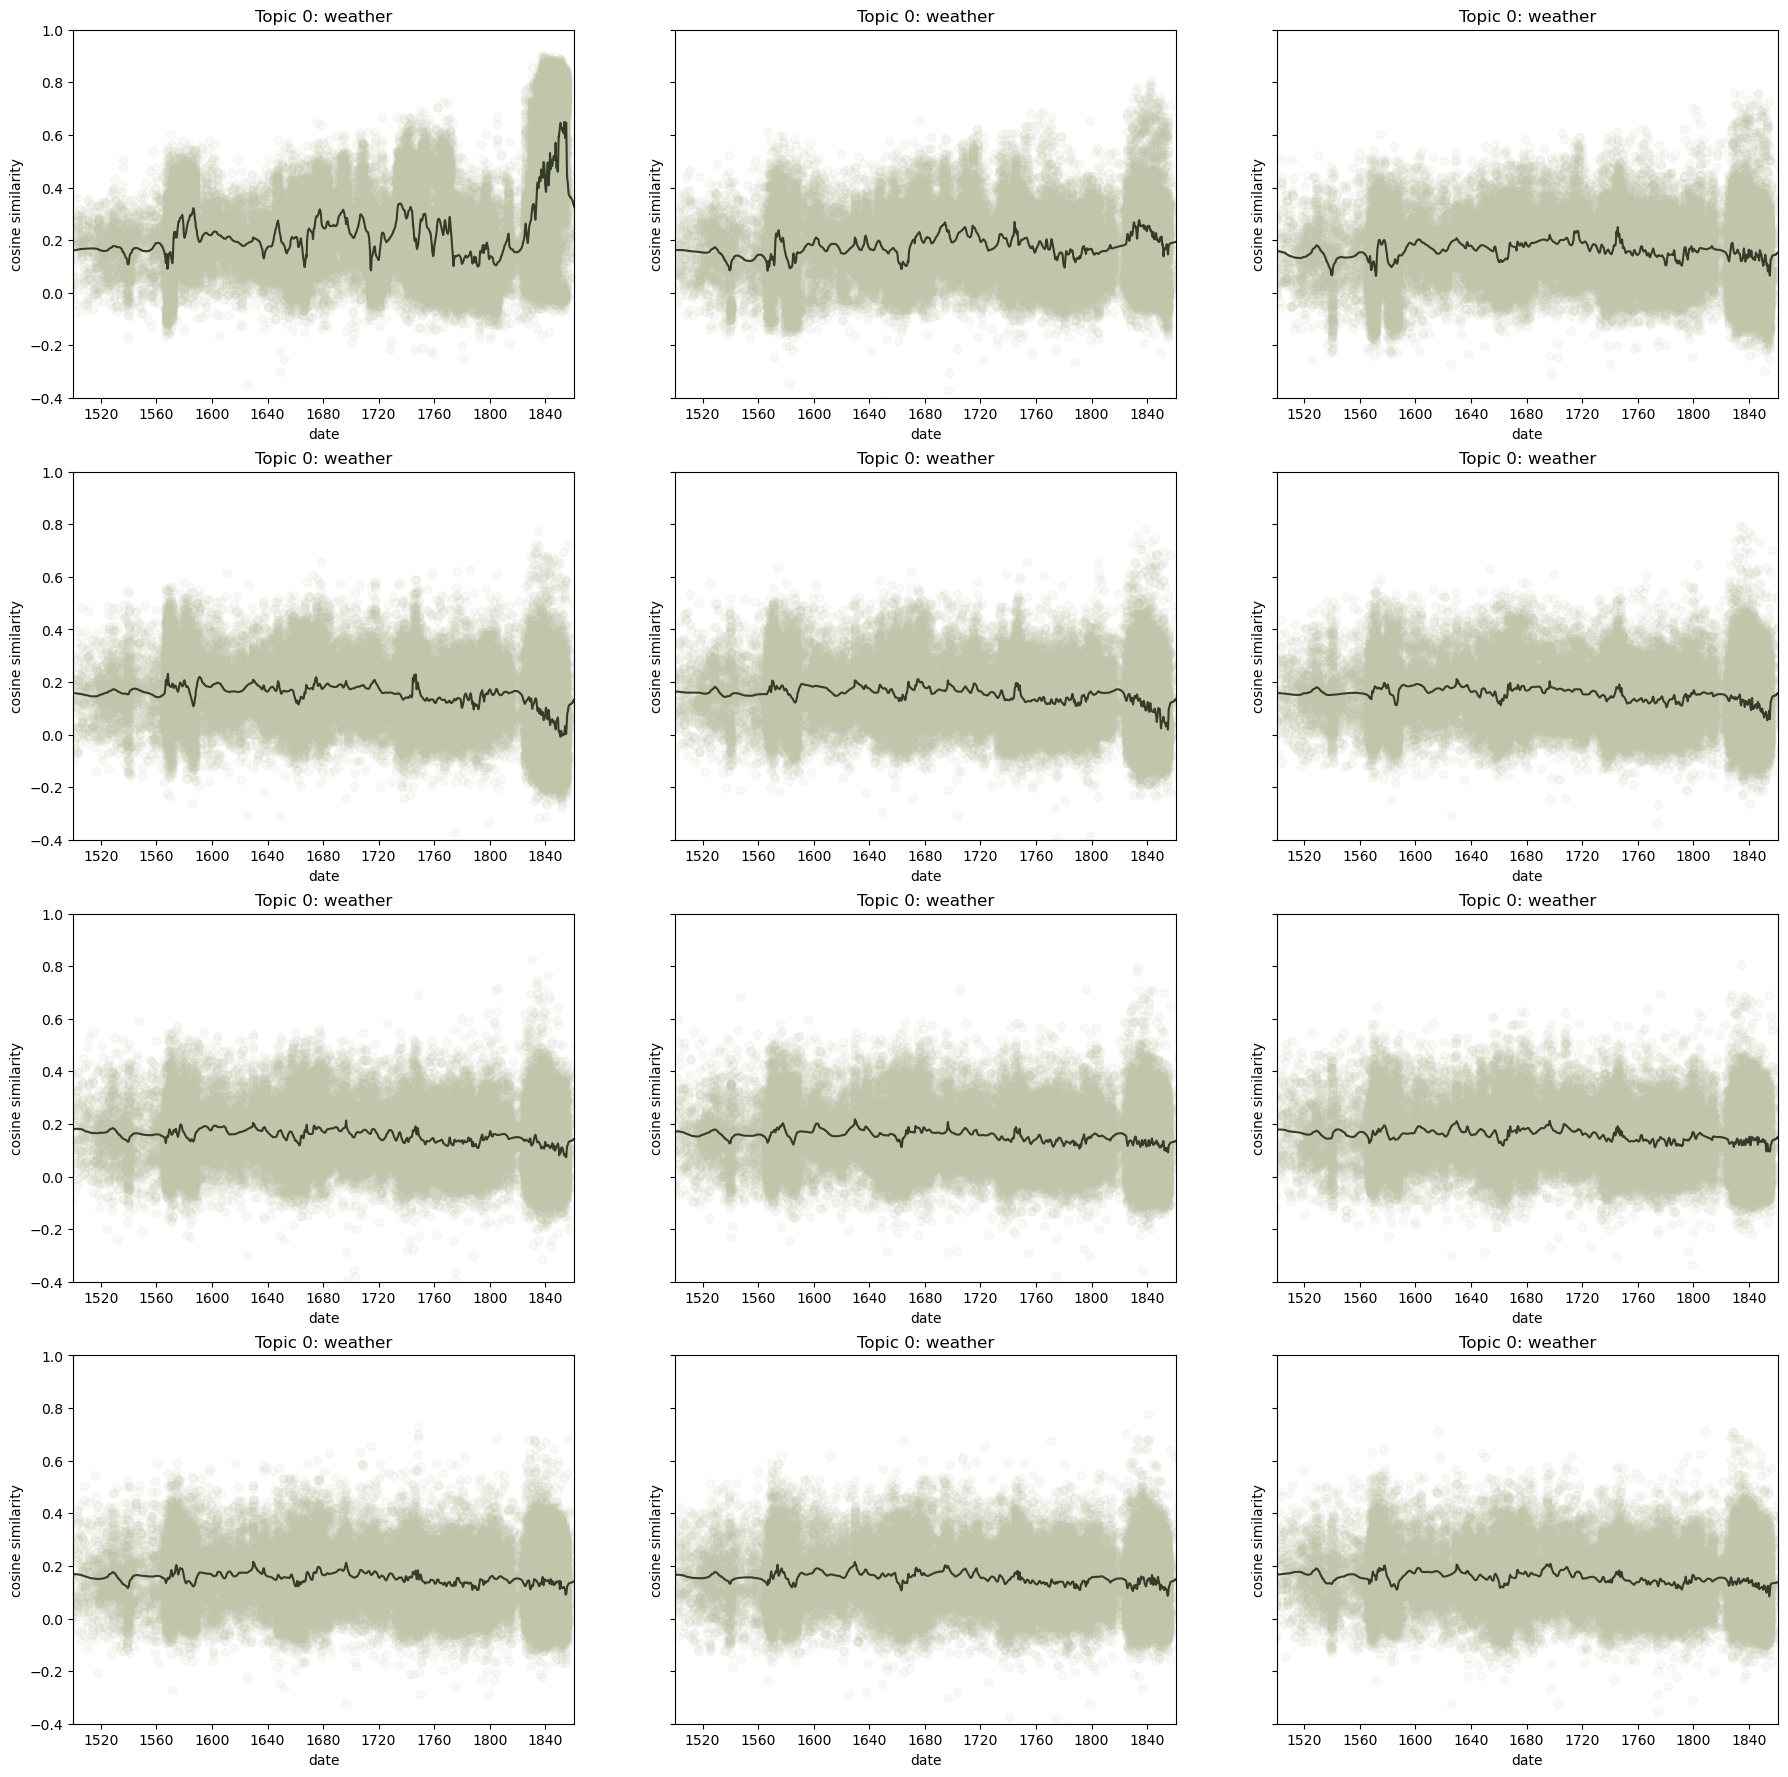

In [10]:
fig, axs = plt.subplots(4, 3, figsize=(22, 22), sharey=True)
axs = axs.flatten()

for i in range(12):
    axs[i].scatter(data_df_date['clean_date'], data_df_date[topic[i]], alpha=0.1, color='#C2C5AA')
    weak_smooth = adaptive_filter(data_df_date[topic[i]].to_numpy(), span = 500)
    axs[i].plot(data_df_date['clean_date'], weak_smooth, c='#333D29')

    axs[i].set_title('Topic 0: weather')
    axs[i].set_ylabel('cosine similarity')
    axs[i].set_xlabel('date')
    axs[i].set_ylim([-0.4, 1])
    axs[i].set_xlim([date(1500, 1, 1), date(1860, 12, 31)])
